In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# some imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# configuration variables
SEED = 42
DEVICE = 'cuda' # change to 'cpu' if training on CPU
BATCH_SIZE = 32

In [2]:
# setup DataLoaders for training and validation as you normally would
kwargs = {'num_workers': 1, 'pin_memory': True} if 'cuda' in DEVICE else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=False, **kwargs)

# define a PyTorch model as you normally would
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()

# setup the optimizer, loss function, and metrics as you normally would
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
def accuracy(y_true, y_pred):
    return np.mean(y_true.numpy() == np.argmax(y_pred.numpy(), axis=1))

In [3]:
# setup a torchfit.Learner instance
import torchfit
learner = torchfit.Learner(model, train_loader, val_loader=test_loader, 
                           optimizer=optimizer, criterion=criterion, metrics=[accuracy], 
                           seed=SEED, device=DEVICE)

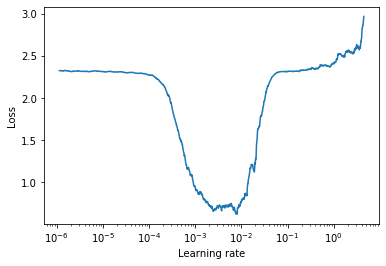

From the plot, select the highest learning rate still associated with a falling loss.


In [4]:
# estimate learning rate
learner.find_lr(num_iter=1500)

In [5]:
learner.fit_onecycle(1e-3, 4)

Epoch 1 / 4
[========================================] 100%	  loss: 0.8584  accuracy: 0.9622  val_loss: 0.1150  val_accuracy: 0.9662

Epoch 2 / 4
[========================================] 100%	  loss: 0.2539  accuracy: 0.9772  val_loss: 0.0677  val_accuracy: 0.9778

Epoch 3 / 4
[========================================] 100%	  loss: 0.1968  accuracy: 0.9819  val_loss: 0.0541  val_accuracy: 0.9831

Epoch 4 / 4
[========================================] 100%	  loss: 0.1651  accuracy: 0.9837  val_loss: 0.0493  val_accuracy: 0.9849



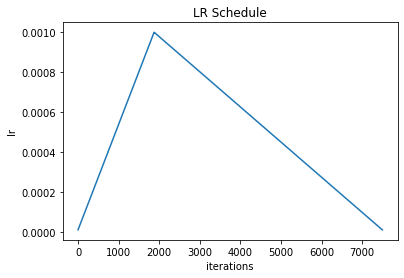

In [6]:
learner.plot('lr')

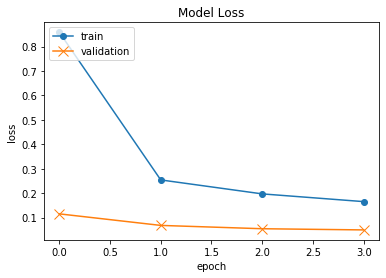

In [7]:
learner.plot('loss')

In [8]:
# generate prediction using the Learner
y_preds = np.argmax(learner.predict(test_loader), axis=-1)[:10]

#  compile the ground truth labels from first batch
y_true = next(iter(test_loader))[1][:10].cpu().detach().numpy()

# display results
import pandas as pd
pd.DataFrame(zip(y_preds, y_true), columns=['Predicted', 'Actual']).head(10)

,Predicted,Actual
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
5,1,1
6,4,4
7,9,9
8,5,5
9,9,9


### Saving and Restoring Models

We can save our model to disk and reload it later in deployment.

In [9]:
learner.save('/tmp/mymodel')

In [10]:
learner.load('/tmp/mymodel')

In [11]:
np.argmax(learner.predict(test_loader), axis=-1)[:5]

array([7, 2, 1, 0, 4])